<small>
---
© 2025 Monobina Bhowmick-Saha  

Original Repo: https://github.com/monobinab-source/ai-ml/tree/main/emeritus-ai-ml/music_transcribe  

Licensed under the MIT License. See the LICENSE file for details.  
---
</small>



## Model Inference & Evaluation



## Predict using the best model and compare predicted output with true MIDI file.
The model outputs predictions in the numpy format. So some extra steps need to be taken to convert the numpy into midi.
I will also try to generate song out of predicted midi.

### A few tools need to be installed before we can start testing

Tool	 ||   Purpose	  ||    Needed for

pretty_midi	||  Work with MIDI files	    ||        Piano roll ↔ MIDI

pydub	   ||     Convert between audio formats	 ||   WAV → MP3 conversion

soundfile	 ||   Save audio files as WAV	    ||      Writing .wav audio

pyfluidsynth	|| Python bindings for MIDI synthesis|| Generate audio from MIDI

fluidsynth	||  Synth engine required by pyfluidsynth ||	Actual audio generation

ffmpeg	 ||     Audio codec for MP3 support	||pydub MP3 conversion




### pretty_midi library
pretty_midi used for working with MIDI files in Python.
In my code:

Load and parse .midi files.

Convert predicted piano rolls back to MIDI (piano_roll_to_midi).

Synthesize audio from MIDI if Fluidsynth is available (midi_obj.fluidsynth()).

### pydub library
Used for: Audio format conversions (e.g., WAV ↔ MP3).

In my code:

Convert .wav to .mp3:
sound = AudioSegment.from_wav(wave_file)
sound.export(mp3_output, format="mp3")

### soundfile library
Used for: Saving audio as .wav.

In my code:

Save synthesized audio:
sf.write(wave_file, audio, samplerate=22050)

### pyfluidsynth
Used for: Synthesizing MIDI into audio using the FluidSynth engine.
In my code:

Required for midi_obj.fluidsynth() to convert MIDI notes into waveform audio.

In [ ]:
!pip install pretty_midi pydub soundfile
!apt install fluidsynth

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 50.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 6.4 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592286 sha256=a0dabfb5b2d92dd2bacb00d123891846f0f62eaa8e859590a9b2d2e552513a5c
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty_midi
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following packages were automatically installed and are no longer required:
  r-cran-colorspace r-cran-munsell
Use 'apt autoremove' to remove them.
The following additional packages will be installed:
  fluid-soundfont-gm libevdev2 libfluidsynth3 libgudev-1.0-0 libinput-bin libinput10
  libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a libqt5dbus5 libqt5gui5 libqt5network5
  libqt5svg5 libqt5widg

In [ ]:
# Install FluidSynth system package and Python wrapper
!apt-get install -y fluidsynth
!pip install pyfluidsynth

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fluidsynth is already the newest version (2.2.5-1).
The following packages were automatically installed and are no longer required:
  r-cran-colorspace r-cran-munsell
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.


### ffmpeg
Used for: Decoding and encoding various audio formats (including MP3).

Required by: pydub to read/write formats like MP3.

In my code:

Enables AudioSegment.from_wav(...) and export(..., format="mp3").

In [ ]:
!pip install pydub
!apt install ffmpeg -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
The following packages were automatically installed and are no longer required:
  r-cran-colorspace r-cran-munsell
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.


## Get the model from GCS bucket

In [ ]:
import os
from google.cloud import storage

# GCS source and local destination
gcs_path = "models_created/models/model_best"
local_path = "/tmp/model_best"

# Download recursively from GCS folder to /tmp
storage_client = storage.Client()
bucket = storage_client.bucket("models_created")
blobs = bucket.list_blobs(prefix="models/model_best")

for blob in blobs:
    dest_path = os.path.join("/tmp", os.path.relpath(blob.name, "models"))
    os.makedirs(os.path.dirname(dest_path), exist_ok=True)
    blob.download_to_filename(dest_path)

print("Model downloaded to /tmp/model_best")


Model downloaded to /tmp/model_best


This code loads a pre-trained TensorFlow SavedModel (in the SavedModel format) for inference only using Keras 3's TFSMLayer, and wraps it into a Keras Sequential model so it can be used like a regular Keras model for predictions.
This layer does not include training configuration, optimizer, etc. It is inference-only.

TFSMLayer: A special Keras layer that wraps a TensorFlow SavedModel, making it usable within a Keras model.

Sequential: Keras' basic model container that stacks layers sequentially.

In [ ]:
from keras.layers import TFSMLayer
from keras import Sequential

# Load SavedModel using TFSMLayer
layer = TFSMLayer("/tmp/model_best", call_endpoint="serving_default") #  tells Keras to use the model's default inference function (usually the one used when exporting the model).

# Wrap it in a Sequential model if needed
model_best = Sequential([layer])

## Get the mp3 file from GCS

In [ ]:
from google.cloud import storage

bucket_name = "audio_and_midi_files"
blob_path = "2018/MIDI-Unprocessed_Chamber1_MID--AUDIO_07_R3_2018_wav--2.mp3"
local_path = "/tmp/MIDI-Unprocessed_Chamber1_MID--AUDIO_07_R3_2018_wav--2.mp3"

# Initialize client
client = storage.Client()
bucket = client.bucket(bucket_name)
blob = bucket.blob(blob_path)
blob.download_to_filename(local_path)

print(f"MP3 file downloaded to: {local_path}")


MP3 file downloaded to: /tmp/MIDI-Unprocessed_Chamber1_MID--AUDIO_07_R3_2018_wav--2.mp3


## Get the corresponding MIDI file from GCS

In [ ]:
from google.cloud import storage

bucket_name = "audio_and_midi_files"
blob_path = "2018/MIDI-Unprocessed_Chamber1_MID--AUDIO_07_R3_2018_wav--2.midi"
local_path = "/tmp/MIDI-Unprocessed_Chamber1_MID--AUDIO_07_R3_2018_wav--2.midi"

# Initialize client
client = storage.Client()
bucket = client.bucket(bucket_name)
blob = bucket.blob(blob_path)
blob.download_to_filename(local_path)

print(f"MP3 file downloaded to: {local_path}")

MP3 file downloaded to: /tmp/MIDI-Unprocessed_Chamber1_MID--AUDIO_07_R3_2018_wav--2.midi


## Use the model to predict
### === Step-by-step Explanation ===

1. Load the MP3 audio file using Librosa at a sample rate of 22050 Hz.
    This gives you the raw waveform (y) and the sample rate (sr).

2. Convert the waveform into a Mel spectrogram with 128 frequency bins.
    These bins roughly correspond to the human auditory range and capture frequency content over time.

3. Convert the Mel spectrogram to a log scale in decibels (log-mel), which better aligns with how humans perceive loudness.

4. Slice the first 100 time frames from the log-mel spectrogram (approx. 2.3 seconds of audio).
    Reshape it to match the CNN input format: (1, 128, 100, 1).

5. Load the trained model (as an inference-only TFSMLayer if saved in SavedModel format).
    Wrap it in a Sequential container for Keras compatibility.

6. Use the model to predict the piano roll — a binary matrix (88 notes × 100 time frames)
    indicating which piano keys are likely active at each time step.

7. Convert the predicted piano roll to a MIDI object using PrettyMIDI.
    Each active note is translated into a `pretty_midi.Note` with start and end times.

8. Save the MIDI file to `/tmp`.

9. Synthesize the MIDI into a WAV file using FluidSynth.
   This generates audio that can be listened to.

10. Convert the WAV file to MP3 using pydub’s AudioSegment module.

Result: I've built an end-to-end pipeline that converts audio → predicted MIDI → synthesized MP3 output.


In [ ]:
import librosa
import numpy as np
import pretty_midi
from pydub import AudioSegment
import soundfile as sf
import os
from keras import Sequential
from keras.layers import TFSMLayer

# --- Step 1: Load audio and get predicted piano roll ---
mp3_path = "/tmp/MIDI-Unprocessed_Chamber1_MID--AUDIO_07_R3_2018_wav--2.mp3"
y, sr = librosa.load(mp3_path, sr=22050)
mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
log_mel = librosa.power_to_db(mel_spec, ref=np.max)

# Take first 100 frames (or process in chunks)
input_slice = log_mel[:, :100].reshape(1, 128, 100, 1)

# Since I am loading the model from /tmp folder. It becomes inference only layer and it behaves differently than full model.
# Wrap the inference layer
if not isinstance(model_best, Sequential):
    model_best = Sequential([model_best])

# --- Predict ---
raw_pred = model_best.predict(input_slice)

# Extract actual output tensor
if isinstance(raw_pred, dict):
    # Automatically get the first value in the dict
    raw_pred = list(raw_pred.values())[0]

# If it's a TensorFlow tensor, convert to NumPy
if hasattr(raw_pred, "numpy"):
    raw_pred = raw_pred.numpy()

# If it's still batched (shape: [1, 88, 100]), remove batch dimension
if raw_pred.ndim == 3 and raw_pred.shape[0] == 1:
    raw_pred = raw_pred[0]

# Now it's safe to threshold
pred_binary = (raw_pred > 0.5).astype(np.int32)  # raw_pred shape should be (88, 100)

print("Predicted piano roll shape:", pred_binary.shape)

# --- Step 2: Convert piano roll to MIDI ---
def piano_roll_to_midi(piano_roll, fs=100):
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=0)  # Acoustic Grand Piano

    for note_num in range(88):  # MIDI note numbers 21–108
        midi_note = note_num + 21
        onsets = np.where(np.diff(piano_roll[note_num, :], prepend=0) == 1)[0]
        offsets = np.where(np.diff(piano_roll[note_num, :], prepend=0) == -1)[0]

        # Make sure each onset has a matching offset
        if len(offsets) > 0 and (len(onsets) > len(offsets)):
            onsets = onsets[:len(offsets)]

        for onset, offset in zip(onsets, offsets):
            start = onset / fs
            end = offset / fs
            note = pretty_midi.Note(
                velocity=100, pitch=midi_note, start=start, end=end
            )
            instrument.notes.append(note)

    pm.instruments.append(instrument)
    return pm

midi_obj = piano_roll_to_midi(pred_binary)
midi_file = "/tmp/predicted_MIDI-Unprocessed_Chamber1_MID--AUDIO_07_R3_2018_wav--2.midi"
midi_obj.write(midi_file)

# --- Step 3: Convert MIDI to audio (WAV or MP3) ---
# Option A: using FluidSynth (if installed)
wave_file = "/tmp/predicted_output_MIDI-Unprocessed_Chamber1_MID--AUDIO_07_R3_2018_wav--2.wav"
midi_obj.fluidsynth(fs=22050)
audio = midi_obj.synthesize()
sf.write(wave_file, audio, samplerate=22050)

# Optionally convert to MP3
sound = AudioSegment.from_wav(wave_file)
mp3_output = "/tmp/predicted_output_MIDI-Unprocessed_Chamber1_MID--AUDIO_07_R3_2018_wav--2.mp3"
sound.export(mp3_output, format="mp3")

print("MIDI and audio generated successfully.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
Predicted piano roll shape: (88, 100)
MIDI and audio generated successfully.


## Evaluation of Predicted Audio with True Audio
1. Predicted audio file is short
(1/100 th of the size of true audio)
2. Predicted audio is of low quality

Hence the comparison of predicted audio and true audio did not turn out well. It may be due to:
1. the notes are not predicted properly
2. synthesized audio if low quality

## Evaluation of MIDI Files
The below script compares a predicted MIDI file (generated by a model) with the true/original MIDI file to evaluate how accurate the predicted piano roll is in terms of active notes.

I used precision, recall, and F1 score to perform the evaluation.

In [ ]:
import pretty_midi
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score

def midi_to_binary_roll(midi_path, fs=100):
    midi = pretty_midi.PrettyMIDI(midi_path)
    roll = midi.get_piano_roll(fs=fs)[21:109]  # (88, T)
    return (roll > 0).astype(int)

# Load both MIDI files
pred_roll = midi_to_binary_roll("/tmp/predicted_MIDI-Unprocessed_Chamber1_MID--AUDIO_07_R3_2018_wav--2.midi")
true_roll = midi_to_binary_roll("/tmp/MIDI-Unprocessed_Chamber1_MID--AUDIO_07_R3_2018_wav--2.midi")
true_roll = true_roll[:, :100]

print("Predicted non-zero notes:", np.count_nonzero(pred_roll))
print("True non-zero notes     :", np.count_nonzero(true_roll))

# Align lengths
T = min(pred_roll.shape[1], true_roll.shape[1])
pred_flat = pred_roll[:, :T].flatten()
true_flat = true_roll[:, :T].flatten()

# Evaluate
f1 = f1_score(true_flat, pred_flat)
precision = precision_score(true_flat, pred_flat)
recall = recall_score(true_flat, pred_flat)

print(f"F1 Score   : {f1:.4f}")
print(f"Precision  : {precision:.4f}")
print(f"Recall     : {recall:.4f}")


Predicted non-zero notes: 222
True non-zero notes     : 0
F1 Score   : 0.0000
Precision  : 0.0000
Recall     : 0.0000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Predict entire MIDI?
Let's try ot predict the MIDI for the entire MP3 file using your model. Below listed are important considerations:

### What's Possible
Split the MP3 file into chunks of fixed size (e.g., 100 frames of log-mel spectrogram), predict each chunk separately using the model, then stitch the predictions together to get the full-length piano roll and MIDI.

### Potential Challenges
Model Input Constraints
The CNN model was trained on fixed-size input slices like (128, 100, 1) (i.e., 100 time frames).
So I can't feed the whole song at once unless it's that exact shape.

### Memory & Performance
Long audio files result in many overlapping slices → high memory usage.
→ I must batch the predictions in chunks.

### Edge Transitions
Predictions made chunk-by-chunk may have:

a. cut-off notes at chunk boundaries

b. inconsistent timing or missing overlap
→ Consider overlapping windows (e.g., stride < 100) and smoothing results.

### Stitching Predictions
I must:

Concatenate predicted piano rolls along time axis

Convert to MIDI using a consistent time base (fs)



In [ ]:
import numpy as np
# full log-mel spectrogram of the MP3
mp3_path = "/tmp/MIDI-Unprocessed_Chamber1_MID--AUDIO_07_R3_2018_wav--2.mp3"
y, sr = librosa.load(mp3_path, sr=22050)
mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
log_mel = librosa.power_to_db(mel_spec, ref=np.max)

chunk_size = 100
step_size = 100  # or use overlap like 50
piano_roll_predictions = []

for start in range(0, log_mel.shape[1] - chunk_size + 1, step_size):
    slice_chunk = log_mel[:, start:start+chunk_size].reshape(1, 128, 100, 1)
    raw_pred = model_best.predict(slice_chunk)

    # Handle dict output from TFSMLayer
    if isinstance(raw_pred, dict):
        raw_pred = list(raw_pred.values())[0]

    if hasattr(raw_pred, "numpy"):
        raw_pred = raw_pred.numpy()

    # Remove batch dimension if needed
    if raw_pred.ndim == 3 and raw_pred.shape[0] == 1:
        raw_pred = raw_pred[0]
    # trying different threshold values to test notes detection confidence and evaluate output changes
    pred_binary = (raw_pred > 0.1).astype(np.int32)
    piano_roll_predictions.append(pred_binary)

# Stack along time
full_piano_roll = np.concatenate(piano_roll_predictions, axis=1)  # (88, total_time)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━

In [ ]:
print("Full piano roll shape:", full_piano_roll.shape)

Full piano roll shape: (88, 54000)


The predicted piano roll has 88 rows for 88 piano notes from 21 - 108.
54000 is the number of columns for the number of time frame.

Now convert the piano roll prediction into midi and synthesize mp3 out of predicted midi.

In [ ]:
midi_obj = piano_roll_to_midi(full_piano_roll)
midi_file = "/tmp/predicted_full_MIDI-Unprocessed_Chamber1_MID--AUDIO_07_R3_2018_wav--2.midi"
midi_obj.write(midi_file)

# --- Step 3: Convert MIDI to audio (WAV or MP3) ---
# Option A: using FluidSynth (if installed)
wave_file = "/tmp/predicted_full_output_MIDI-Unprocessed_Chamber1_MID--AUDIO_07_R3_2018_wav--2.wav"
midi_obj.fluidsynth(fs=22050)
audio = midi_obj.synthesize()
sf.write(wave_file, audio, samplerate=22050)

# Optionally convert to MP3
sound = AudioSegment.from_wav(wave_file)
mp3_output = "/tmp/predicted_full_output_MIDI-Unprocessed_Chamber1_MID--AUDIO_07_R3_2018_wav--2.mp3"
sound.export(mp3_output, format="mp3")

print("MIDI and audio generated successfully.")

MIDI and audio generated successfully.


In [ ]:
import numpy as np
from sklearn.metrics import f1_score

# Load both MIDI files
full_pred_roll = midi_to_binary_roll("/tmp/predicted_full_MIDI-Unprocessed_Chamber1_MID--AUDIO_07_R3_2018_wav--2.midi")
full_true_roll = midi_to_binary_roll("/tmp/MIDI-Unprocessed_Chamber1_MID--AUDIO_07_R3_2018_wav--2.midi")


print("Predicted non-zero notes:", np.count_nonzero(full_pred_roll))
print("True non-zero notes     :", np.count_nonzero(full_true_roll))

# Align lengths
T = min(full_pred_roll.shape[1], full_true_roll.shape[1])
y_true = full_true_roll[:, :T].flatten()
y_pred = full_pred_roll[:, :T].flatten()

f1 = f1_score(y_true, y_pred)
print(f"F1 Score: {f1:.4f}")


Predicted non-zero notes: 172977
True non-zero notes     : 371411
F1 Score: 0.0392


### Played with different threshold values to change confidence values and I could see small changes in non-zero notes and F1 scores.
Threshold = 0.5:
Predicted non-zero notes: 141689
True non-zero notes     : 371411
F1 Score: 0.0340

Threshold = 0.3:
Predicted non-zero notes: 155164
True non-zero notes     : 371411
F1 Score: 0.0357

Threshold = 0.2:
Predicted non-zero notes: 162112
True non-zero notes     : 371411
F1 Score: 0.0364

Threshold = 0.1:
Predicted non-zero notes: 172977
True non-zero notes     : 371411
F1 Score: 0.0392

### Compare and Visualize Predicted vs True MIDI
Using pretty_midi and matplotlib to compare the predicted and true MIDI files.

I will comapre in the following ways:

1. Plot piano roll of both MIDI files.

2. Show duration of each piece.

3. Show note pitch range.

4. Show total number of notes or histogram of note usage.

Predicted MIDI Duration: 539.99s | Note range: 21–108 | Notes: 108934
True MIDI Duration     : 1255.15s | Note range: 28–97 | Notes: 12190


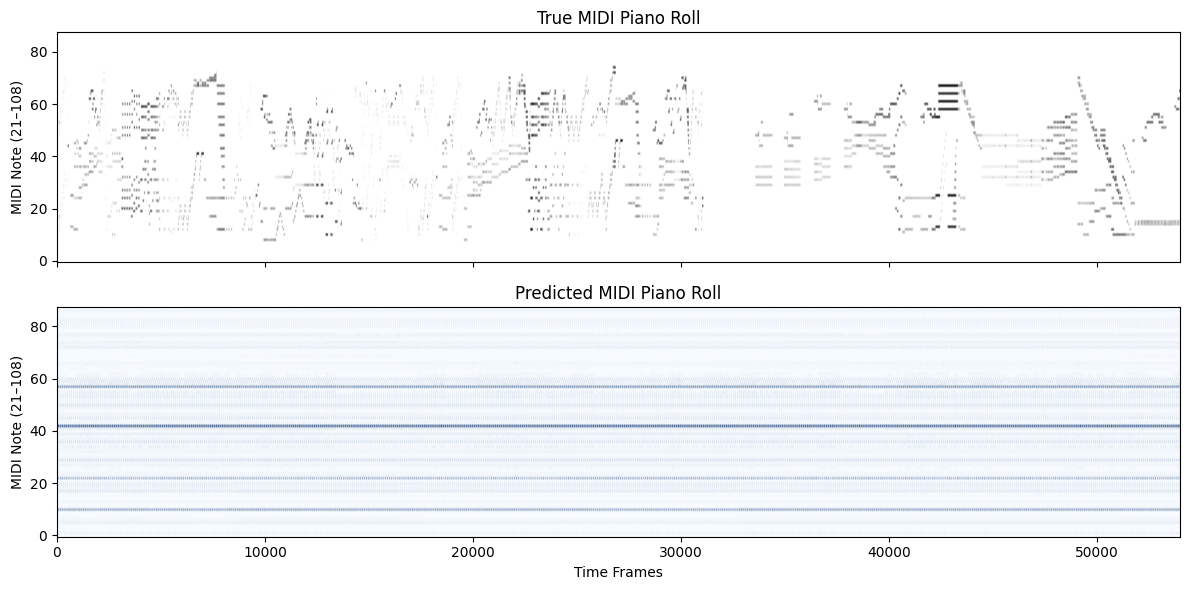

In [ ]:
import pretty_midi
import matplotlib.pyplot as plt
import numpy as np

# File paths
predicted_midi_path = "/tmp/predicted_full_MIDI-Unprocessed_Chamber1_MID--AUDIO_07_R3_2018_wav--2.midi"
true_midi_path = "/tmp/MIDI-Unprocessed_Chamber1_MID--AUDIO_07_R3_2018_wav--2.midi"

# Load MIDI files
pred_midi = pretty_midi.PrettyMIDI(predicted_midi_path)
true_midi = pretty_midi.PrettyMIDI(true_midi_path)

# Get piano rolls
fs = 100  # frames per second
pred_roll = pred_midi.get_piano_roll(fs=fs)[21:109]
true_roll = true_midi.get_piano_roll(fs=fs)[21:109]

# Get durations
pred_duration = pred_midi.get_end_time()
true_duration = true_midi.get_end_time()

# Get note pitch ranges
def get_note_range(pm):
    notes = [n.pitch for ins in pm.instruments for n in ins.notes]
    return min(notes), max(notes), len(notes)

pred_min, pred_max, pred_count = get_note_range(pred_midi)
true_min, true_max, true_count = get_note_range(true_midi)

# Print summary
print(f"Predicted MIDI Duration: {pred_duration:.2f}s | Note range: {pred_min}–{pred_max} | Notes: {pred_count}")
print(f"True MIDI Duration     : {true_duration:.2f}s | Note range: {true_min}–{true_max} | Notes: {true_count}")

# Plot piano rolls
fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

axs[0].imshow(true_roll, origin='lower', aspect='auto', cmap='Greys')
axs[0].set_title("True MIDI Piano Roll")
axs[0].set_ylabel("MIDI Note (21–108)")

axs[1].imshow(pred_roll, origin='lower', aspect='auto', cmap='Blues')
axs[1].set_title("Predicted MIDI Piano Roll")
axs[1].set_xlabel("Time Frames")
axs[1].set_ylabel("MIDI Note (21–108)")

plt.tight_layout()
plt.show()


### Compare note usage as histograms:

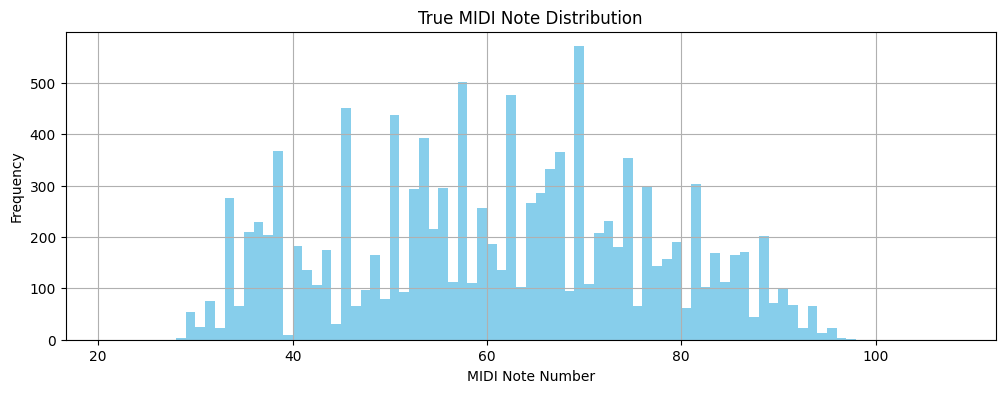

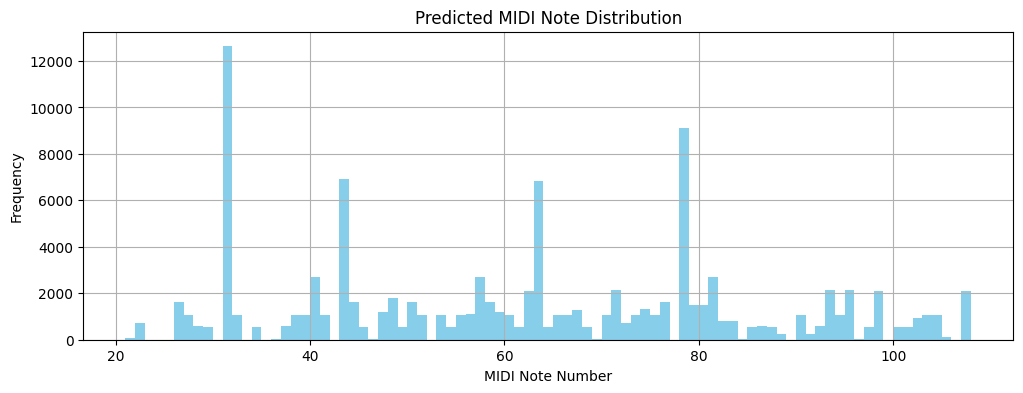

In [ ]:
def plot_note_histogram(pm, title):
    notes = [n.pitch for ins in pm.instruments for n in ins.notes]
    plt.hist(notes, bins=np.arange(21, 109), color='skyblue')
    plt.title(title)
    plt.xlabel("MIDI Note Number")
    plt.ylabel("Frequency")
    plt.grid(True)

plt.figure(figsize=(12, 4))
plot_note_histogram(true_midi, "True MIDI Note Distribution")
plt.figure(figsize=(12, 4))
plot_note_histogram(pred_midi, "Predicted MIDI Note Distribution")
plt.show()


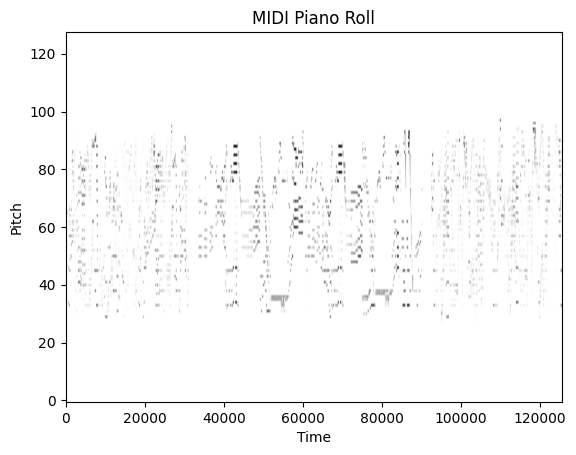

In [ ]:
import pretty_midi
import matplotlib.pyplot as plt

midi = pretty_midi.PrettyMIDI("/tmp/MIDI-Unprocessed_Chamber1_MID--AUDIO_07_R3_2018_wav--2.midi")
piano_roll = midi.get_piano_roll()

plt.imshow(piano_roll, aspect='auto', origin='lower', cmap='gray_r')
plt.title("MIDI Piano Roll")
plt.xlabel("Time")
plt.ylabel("Pitch")
plt.savefig("midi_visual.png")


In [ ]:
midi_obj = piano_roll_to_midi(full_piano_roll)
midi_file = "/tmp/MIDI-Unprocessed_Chamber1_MID--AUDIO_07_R3_2018_wav--2.midi"
midi_obj.write(midi_file)

# --- Step 3: Convert MIDI to audio (WAV or MP3) ---
# Option A: using FluidSynth (if installed)
wave_file = "/tmp/MIDI-synthesised__Chamber1_MID--AUDIO_07_R3_2018_wav--2.wav"
midi_obj.fluidsynth(fs=22050)
audio = midi_obj.synthesize()
sf.write(wave_file, audio, samplerate=22050)

# Optionally convert to MP3
sound = AudioSegment.from_wav(wave_file)
mp3_output = "/tmp/MIDI-synthesised__Chamber1_MID--AUDIO_07_R3_2018_wav--2.mp3"
sound.export(mp3_output, format="mp3")

print("MIDI and audio generated successfully.")

MIDI and audio generated successfully.


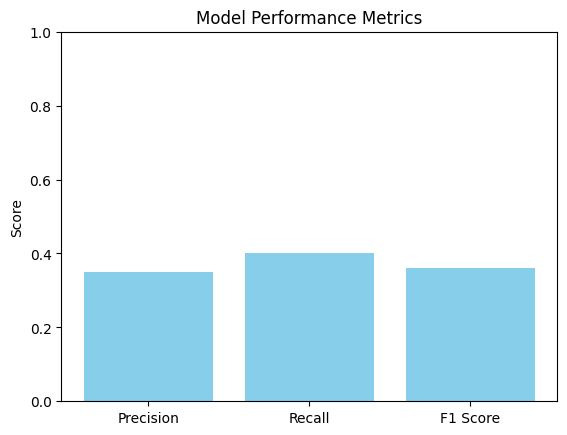

In [ ]:
import matplotlib.pyplot as plt

metrics = ['Precision', 'Recall', 'F1 Score']
values = [0.35, 0.40, 0.36]  # Example CNN metrics

plt.bar(metrics, values, color='skyblue')
plt.ylim(0, 1)
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.show()
